In [1]:
%matplotlib widget
import cv2
import os
import json
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

## Manually rotate and crop image ("horizon" correction)

pre_crop (96, 84, 608, 300)


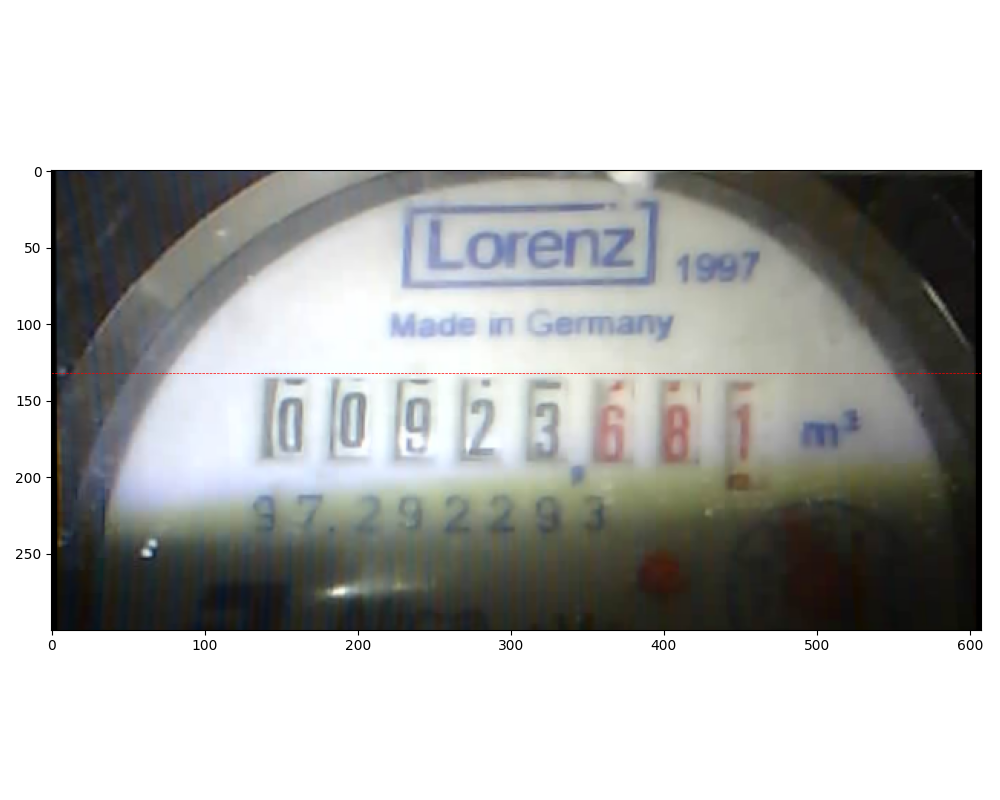

In [2]:
meter_model = "lorenz_1997"
camera_model = "espcam_120_deg"

meter_model_path = os.path.join("automatic_meter_reader", "meter_models", meter_model)
if not os.path.isdir(meter_model_path):
    os.mkdir(meter_model_path)

img_file = r"tests\test_image2.jpg"
horizont_y = 132
pre_rotation_angle_deg = 90.2
pre_crop_percent = (0.12, 0.14, 0.76, 0.5)

#horizont_y = 220
#pre_rotation_angle_deg = 0.0
#pre_crop_percent = (0.0, 0.0, 1.0, 1.0)

def rotate_image(image, angle):
    image_center = tuple((np.array(image.shape[1::-1]) - 1.0) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

with open(os.path.join("automatic_meter_reader", "cameras", "%s.json" % (camera_model)), "r") as f:
    camcalib = json.load(f)
camera_matrix = np.resize(np.array(camcalib["camera_matrix"]), (3, 3))
distortion_coefs = np.resize(np.array(camcalib["distortion_coefs"]), (1, len(camcalib["distortion_coefs"])))
new_camera_matrix = np.resize(np.array(camcalib["new_camera_matrix"]), (3, 3))

img = cv2.imread(img_file)
img = cv2.undistort(img, camera_matrix, distortion_coefs, None, new_camera_matrix)
img = rotate_image(img, pre_rotation_angle_deg)

px0, py0, pdx, pdy = pre_crop_percent
pre_crop = int(px0 * img.shape[1]), int(py0 * img.shape[0]), int(pdx * img.shape[1]), int(pdy * img.shape[0])
print("pre_crop", pre_crop)
x0, y0, dx, dy = pre_crop
img = img[y0:y0 + dy, x0:x0 + dx]

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.gca().add_patch(patches.Rectangle((x0 - 0.5, y0 - 0.5), dx, dy, linewidth=1.0, ls="-", edgecolor='r', alpha=0.5, facecolor='none'))
plt.axhline(horizont_y, lw=0.5, ls="--", c="r")
plt.tight_layout();

# Define templates, register and dial ROIs

In [3]:
# Templates ROIs


"""
# gas_bk25
template_rois = [
    #(641 - 96, 238 - 150, 45, 45), # m3
    (338, 45, 100, 25),
    (127 - 96, 300 - 150, 85, 35), # Elster
    (444 - 96, 300 - 150, 95, 35), # Mainz
]

# Digits
register_roi = (168 - 96, 235 - 150, 357, 50)
num_digits = 7
digit_width = 35
digits_num_integers = 5
"""

"""
# wehrle_cold
template_rois = [
    (666, 185, 55, 45), # m3
    (35, 280, 75, 81), # Logo
    #(340, 380, 160, 170), # Wheel
    (258, 310, 25, 50),
]

# Digits
register_roi = (135, 106, 466, 72)
num_digits = 8
digit_width = 44
digits_num_integers = 5
"""

"""
# hot
template_rois = [
    (675, 230, 55, 45), # m3
    (46, 320, 74, 82), # Logo
    #(340, 380, 160, 170), # Wheel
    (262, 350, 28, 50),
]

# Digits
register_roi = (154, 150, 450, 71)
num_digits = 8
digit_width = 42
digits_num_integers = 5
"""

# lorenz 1997
template_rois = [
    (227, 15, 170, 65), # Lorenz
    (483, 148, 50, 40), # m3
    (126, 203, 55, 40), #  97
]

# Digits
register_roi = (138, 135, 330, 55)
num_digits = 8
digit_width = 30
digits_num_integers = 5

## Generate config

In [4]:
config = {
    "name": meter_model,
    "templates": [],
    "pre_rotation_angle_deg": pre_rotation_angle_deg,
    "pre_crop": list(pre_crop),
    "register": {"digits": [] },
}

for i, (x0, y0, dx, dy) in enumerate(template_rois):
    template_img = img[y0:y0+dy, x0:x0+dx]
    template_img_file = "template_%d.jpg" % (i)
    cv2.imwrite(os.path.join(meter_model_path, template_img_file), template_img)
    config["templates"].append({
        "roi": [x0, y0, dx, dy],
        "file": template_img_file,
    })

x0, y0, dx, dy = register_roi
config["register"]["roi"] = list(register_roi)
for i in range(num_digits):
    spacing_x = (dx - num_digits * digit_width) / (num_digits - 1)
    nx0 = int(x0 + i * (digit_width + spacing_x))
    config["register"]["digits"].append({
        "roi": [nx0, y0, digit_width, dy],
        "multiplier": 10.0 ** (digits_num_integers - i - 1)
    })

## Visualize

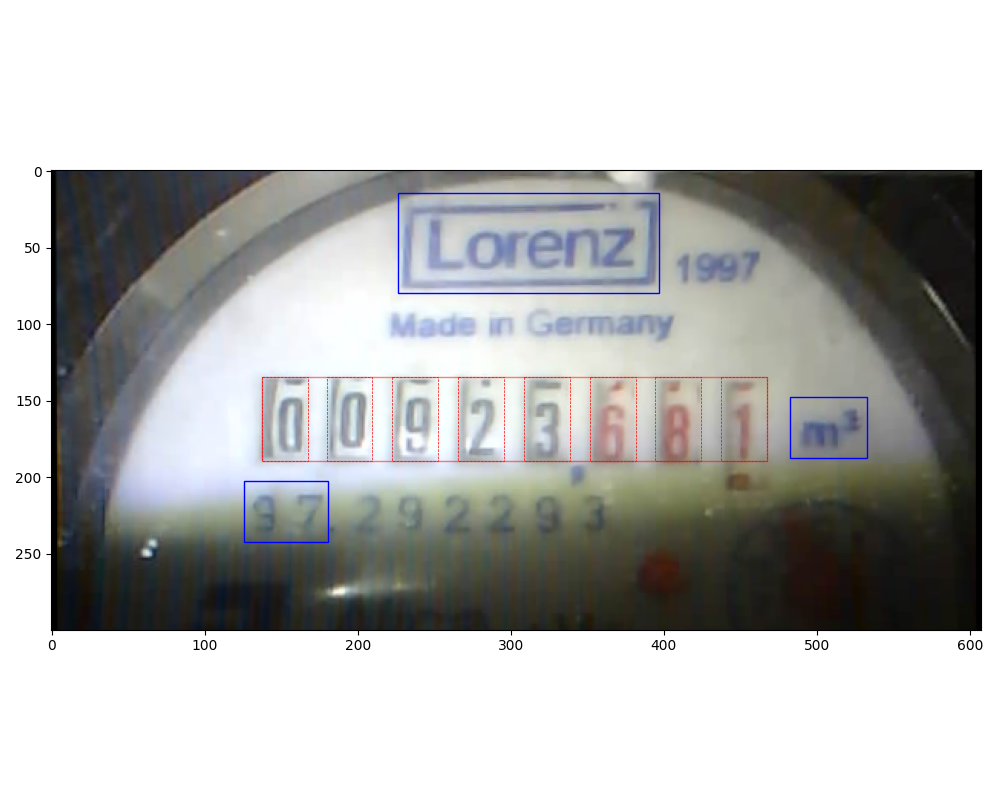

In [5]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Templates
for template_conf in config["templates"]:
    x0, y0, dx, dy = template_conf["roi"]
    template_img = img[y0:y0+dy, x0:x0+dx]
    plt.gca().add_patch(patches.Rectangle((x0 - 0.5, y0 - 0.5), dx, dy, linewidth=1.0, ls="-", edgecolor="b", alpha=1.0, facecolor="none"))
    
# Register
x0, y0, dx, dy = config["register"]["roi"]
plt.gca().add_patch(patches.Rectangle((x0 - 0.5, y0 - 0.5), dx, dy, linewidth=1.0, ls="-", edgecolor='r', alpha=0.5, facecolor='none'))
for digit_conf in config["register"]["digits"]:
    x0, y0, dx, dy = digit_conf["roi"]
    plt.gca().add_patch(patches.Rectangle((x0 - 0.5, y0 - 0.5), dx, dy, linewidth=0.5, ls="--", edgecolor='r', alpha=1.0, facecolor='none'))
plt.tight_layout()

# Save config

In [6]:
print(os.path.abspath(meter_model_path))
with open(os.path.join(meter_model_path, "meter_config.json"), "w") as f:
    json.dump(config, f, indent=4)

c:\Users\ardil\OneDrive\Minu\Github\utility_meters\automatic-meter-reader\automatic_meter_reader\meter_models\lorenz_1997
